Ref: https://ithelp.ithome.com.tw/articles/10222575

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets,layers,optimizers,Sequential,metrics

print(tf.__version__)

2.15.0


In [3]:
(x,y),(x_test,y_test) = datasets.cifar10.load_data()
y = tf.squeeze(y,axis=1)
y_test = tf.squeeze(y_test,axis=1)
print(x.shape,y.shape)

170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000,)


In [4]:
print(x.shape,y.shape)

(50000, 32, 32, 3) (50000,)


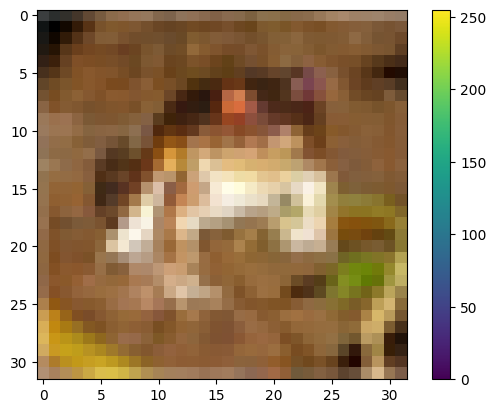

In [5]:
plt.figure()
plt.imshow(x[0])
plt.colorbar()
plt.grid(False)

In [6]:
def feature_scale(x,y):
  x = tf.cast(x,dtype=tf.float32)/255.
  y = tf.cast(y,dtype=tf.int32)
  return x,y

In [7]:
# 利用keras建構VGG16的隱藏層
vgg_layers_16 = [
    #stack1
    layers.Conv2D(64,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(64,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
    #stack2
    layers.Conv2D(128,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(128,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
    #stack3
    layers.Conv2D(256,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(256,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(256,kernel_size=[1,1],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
    #stack4
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[1,1],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same'),
    #stack5
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[3,3],padding='same',activation=tf.nn.relu),
    layers.Conv2D(512,kernel_size=[1,1],padding='same',activation=tf.nn.relu),
    layers.MaxPool2D(pool_size=[2,2],strides=2,padding='same')
]

# 此處全連接層與論文所建置的有所不同，因考量參數量
fc_layers =[
    layers.Dense(256,activation=tf.nn.relu),
    layers.Dense(256,activation=tf.nn.relu),
    layers.Dense(10,activation=None),
]

In [8]:
vgg_16 = Sequential(vgg_layers_16)
vgg_16.build(input_shape=[None,32,32,3])
fc = Sequential(fc_layers)
fc.build(input_shape=[None,512])

optimizer = optimizers.Adam(learning_rate=0.0001)

In [9]:
data = tf.data.Dataset.from_tensor_slices((x,y))
data = data.map(feature_scale).shuffle(10000).batch(256)

data_test = tf.data.Dataset.from_tensor_slices((x_test,y_test))
data_test = data_test.map(feature_scale).batch(256)

In [10]:
data_iter = iter(data)
samples = next(data_iter)
print(samples[0].shape,samples[1].shape)

(256, 32, 32, 3) (256,)


In [11]:
# 查看模型架構
vgg_16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                   

In [12]:
variables = vgg_16.trainable_variables + fc.trainable_variables
for i in range(10):
  for step,(x,y) in enumerate(data):
    with tf.GradientTape() as tape:
      logits = vgg_16(x)
      logits = tf.reshape(logits,[-1,512])
      logits = fc(logits)
      y_one_hot = tf.one_hot(y,depth=10)
      loss = tf.losses.categorical_crossentropy(y_one_hot,logits,from_logits=True)
      loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss,variables)
    optimizer.apply_gradients(zip(grads,variables))

    if step %100==0:
      print('Epoch: ',i,'\tStep: ',step,'\tloss: ',float(loss))
  total_loss = 0
  total_num=0
  for x,y in data_test:

    logits = vgg_16(x)
    logits = tf.reshape(logits,[-1,512])

    logits = fc(logits)
    prob = tf.nn.softmax(logits,axis=1)
    pred = tf.argmax(prob,axis=1)

    pred = tf.cast(pred,dtype=tf.int32)
    correct = tf.equal(pred,y)

    result = tf.reduce_sum(tf.cast(correct,dtype=tf.int32))

    total_loss += int(result)
    total_num += x.shape[0]

  acc = total_loss/total_num
  print(i,'acc:',acc)

Epoch:  0 	Step:  0 	loss:  2.3025949001312256
Epoch:  0 	Step:  100 	loss:  1.9215826988220215
0 acc: 0.3713
Epoch:  1 	Step:  0 	loss:  1.725305199623108
Epoch:  1 	Step:  100 	loss:  1.586243748664856
1 acc: 0.4501
Epoch:  2 	Step:  0 	loss:  1.5128772258758545
Epoch:  2 	Step:  100 	loss:  1.4249149560928345
2 acc: 0.5234
Epoch:  3 	Step:  0 	loss:  1.3067810535430908
Epoch:  3 	Step:  100 	loss:  1.0991648435592651
3 acc: 0.5431
Epoch:  4 	Step:  0 	loss:  1.333243489265442
Epoch:  4 	Step:  100 	loss:  1.140732765197754
4 acc: 0.5924
Epoch:  5 	Step:  0 	loss:  1.0478217601776123
Epoch:  5 	Step:  100 	loss:  1.1199675798416138
5 acc: 0.6294
Epoch:  6 	Step:  0 	loss:  0.9616749286651611
Epoch:  6 	Step:  100 	loss:  0.8816713094711304
6 acc: 0.6046
Epoch:  7 	Step:  0 	loss:  0.9637859463691711
Epoch:  7 	Step:  100 	loss:  0.9099973440170288
7 acc: 0.6638
Epoch:  8 	Step:  0 	loss:  0.8623371720314026
Epoch:  8 	Step:  100 	loss:  0.7875192165374756
8 acc: 0.6668
Epoch:  9 	Ste

In [13]:
total_loss = 0
total_num=0
for x,y in data_test:

  logits = vgg_16(x)
  logits = tf.reshape(logits,[-1,512])

  logits = fc(logits)
  prob = tf.nn.softmax(logits,axis=1)
  pred = tf.argmax(prob,axis=1)

  pred = tf.cast(pred,dtype=tf.int32)
  correct = tf.equal(pred,y)

  result = tf.reduce_sum(tf.cast(correct,dtype=tf.int32))

  total_loss += int(result)
  total_num += x.shape[0]

acc = total_loss/total_num
print(acc)

0.6835
